In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [32]:
#################################
##         Gather Data         ##
#################################
Data = pd.read_csv('ai4i2020.csv')
df = pd.DataFrame(Data)
df


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [33]:
#################################
##         EXPLORE DATA        ##
#################################
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [34]:
print(df['Type'].value_counts())
print(df['Product ID'].value_counts())
#df.describe()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64
Product ID
L57163    1
M24842    1
L57161    1
L57160    1
L57159    1
         ..
L47184    1
L47183    1
L47182    1
L47181    1
M14860    1
Name: count, Length: 10000, dtype: int64


In [35]:
#################################
##         PREPARE DATA        ##
#################################
# 1. Handle missing or zero values
df = df.dropna()

# 2. Convert categorical to numeric
df['Type'] = df['Type'].map({'L': 1, 'M': 2, 'H': 3})
df = df.drop('Product ID', axis=1)

# 3. Separate features (X) and target variable (y)
X = df.drop('Machine failure', axis=1) 
Y = df['Machine failure']

# 4. Split the data
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, stratify=Y, random_state=42)

# 5: Scale the features
scaler = StandardScaler()

# Fit the scaler to the training data and transform both training and test sets
x_train_scaled = scaler.fit_transform(x_train)  # Scale the training set
x_test_scaled = scaler.transform(x_test)        # Scale the test set using the same scaler

In [36]:
###################################
##         TRAIN LR MODEL        ##
###################################

# 1. Create a logistic regression model
lr = LogisticRegression(random_state=42)

# 2. Train the model
lr.fit(x_train_scaled, y_train)

# 3. Make predictions
lr_y_pred_test = lr.predict(x_test_scaled)


In [37]:
###################################
##         TRAIN RF MODEL        ##
###################################

# 1. Create a random forrest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_scaled, y_train)

# 2. Make predictions
rf_y_pred_test = rf.predict(x_test_scaled)

LR accuracy:  0.999
RF accuracy:  0.999
LR Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.97      0.99        68

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000

RF Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.97      0.99        68

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



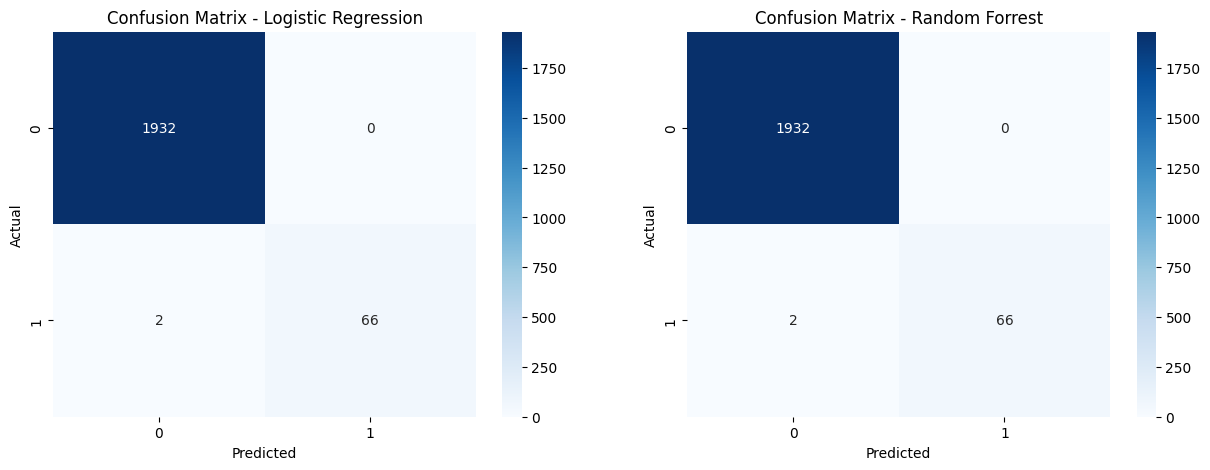

In [38]:
###################################
##         EVALUATE MODEL        ##
###################################

# 1. Calculate accuracy
lr_accuracy = accuracy_score(lr_y_pred_test, y_test)
rf_accuracy = accuracy_score(rf_y_pred_test, y_test)
print('LR accuracy: ', lr_accuracy)
print('RF accuracy: ', rf_accuracy)

# 2. Generate confusion matrix
lr_cm = confusion_matrix(y_test, lr_y_pred_test)
rf_cm = confusion_matrix(y_test, rf_y_pred_test)

# 3. Print classification report
print("LR Classification Report:")
print(classification_report(y_test, lr_y_pred_test))
print("RF Classification Report:")
print(classification_report(y_test, rf_y_pred_test))

# 4. Visualize confusion matrix
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.subplot(1,2,2)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forrest')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

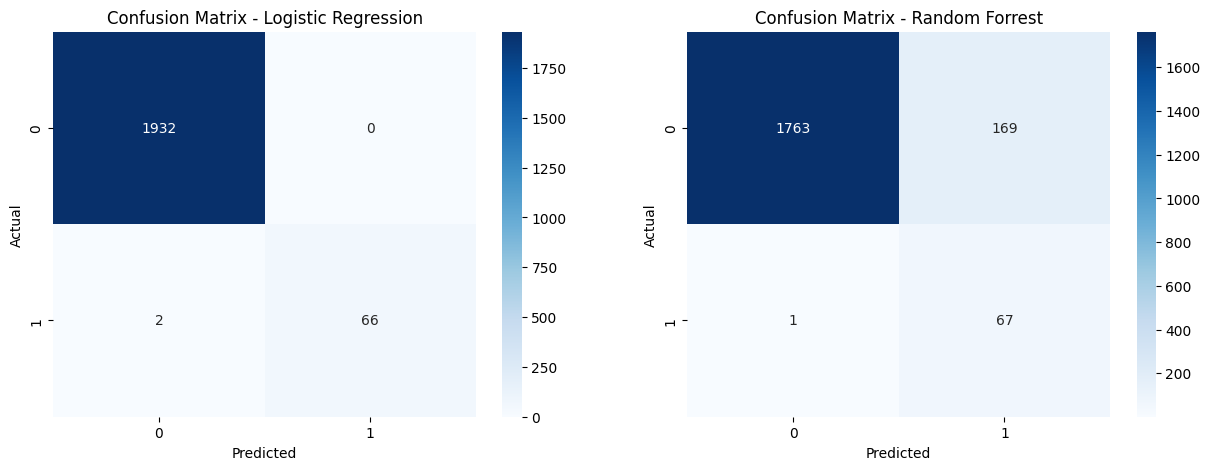

In [39]:
#####################################
##         FINE-TUNE MODELS        ##
#####################################

threshold = 0.01  # Adjust threshold here
lr_y_prob_test = lr.predict_proba(x_test_scaled)[:, 1]
lr_y_pred_test = (lr_y_prob_test >= threshold).astype(int)

rf_y_prob_test = rf.predict_proba(x_test_scaled)[:, 1]
rf_y_pred_test = (rf_y_prob_test >= threshold).astype(int)

lr_cm = confusion_matrix(y_test, lr_y_pred_test)
rf_cm = confusion_matrix(y_test, rf_y_pred_test)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(1,2,2)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forrest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

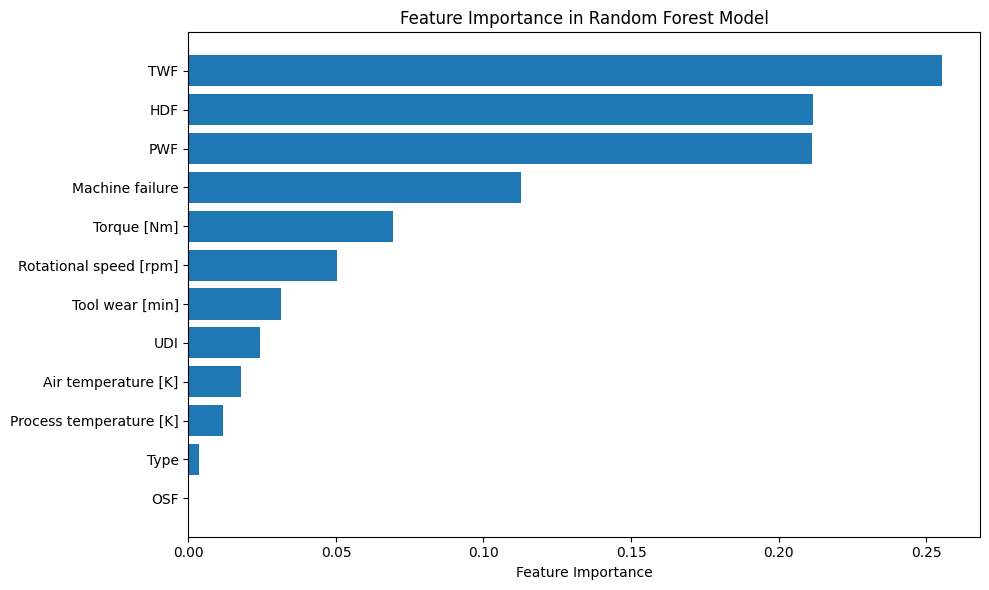


Feature Importance:
OSF: 0.0003
Type: 0.0036
Process temperature [K]: 0.0116
Air temperature [K]: 0.0179
UDI: 0.0244
Tool wear [min]: 0.0315
Rotational speed [rpm]: 0.0502
Torque [Nm]: 0.0693
Machine failure: 0.1126
PWF: 0.2115
HDF: 0.2117
TWF: 0.2555


In [40]:
# Feature importance
# This shows how much each feature contributes to the model's decisions
feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(df.columns)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()
plt.show()

# Print feature importance
print("\nFeature Importance:")
for i in sorted_idx:
    print(f"{df.columns[i]}: {feature_importance[i]:.4f}")